Backtest Quant Model
BUFN-736
Iordan Koulov, Ksenia Popovich, Aman Sharma, Pranav Senthil


In [ ]:
!pip install yfinance

ERROR: Operation cancelled by user


In [ ]:
import glob
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import pearsonr
from scipy.stats import zscore
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import durbin_watson
from scipy.stats.mstats import gmean
import statistics; statistics.geometric_mean
from statsmodels.iolib.summary2 import summary_col
import yfinance as yf
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

# Load and process returns data

In [ ]:
returns5 = pd.read_csv('/content/drive/Shareddrives/BUFN 736 - Quant Strategy /BacktestProject/Returns/Returns3.csv', index_col= None, header= 0)

In [ ]:
returns = pd.read_csv('/content/drive/Shareddrives/BUFN 736 - Quant Strategy /BacktestProject/AlphaBuild/data/returns.csv', index_col= None, header= 0)

In [ ]:
returns['date']= pd.to_datetime(returns['date'], format='%Y-%m-%d')
returns['YEAR'] = pd.DatetimeIndex(returns['date']).year
returns['month'] = pd.DatetimeIndex(returns['date']).month
returns = returns[returns["YEAR"] >= 1985]
#returns = returns.rename(columns ={'LPERMNO':'PERMNO', 'trt1m': 'm_returns', 'PERMCO' : 'PERMCO', 'prccm' :"closing_price", 'cshtrm' : 'trading_volume'})
#returns['returns'] = returns['m_returns'] /100  # returns were expressed as percentage points not as percent
returns = returns.loc[(returns["PRC"] >= 0)] # we filter out stocks which are not liquid, we will take care of size and EP and BM later

In [ ]:
%%capture
returns['RET'] = returns['RET'].str.replace("[A-Z]","")
returns = returns[returns['RET'].astype(bool)]
returns['RET'] = returns['RET'].astype(float)

In [ ]:
returns1 = returns.groupby(['YEAR', 'PERMNO', 'CUSIP']).agg({'RET': lambda x: ((1+x).product() ** (12/float(len(x)))-1), 'PRC':'mean'}) # Annualize monthly returns
#returns1 = returns1.to_frame()
returns1 = returns1.reset_index()
#returns1['cusip'] = returns1.cusip.astype(str).str[:8] # we go to 8 digit cusip codes
#returns1['yr1Ret'] = returns1.groupby('PERMNO')['RET'].shift(1) # shift returns
returns1['yr1Ret'] = returns1['RET']
returns1 = returns1.loc[(returns1["PRC"] >= 5)] # we filter out stocks which are not liquid, we will take care of size and EP and BM later

## Dictionary for Industry Code

In [ ]:
%%capture
returns5['PERMNO'] = returns5['LPERMNO']
company_dict = returns5[['sic','PERMNO','tic']]
company_dict['sic'] = company_dict['sic'].astype(str)
company_dict['sic_short'] = company_dict.sic.astype(str).str[:2].astype(int)
company_dict = company_dict.drop_duplicates()
company_dict = company_dict.dropna()

## Shares Dataset (there is actually a size variable built for us and this section is not needed)

The fundamentals dataset has very few missing datapoints with shares outstanding, we pull this data, clean it and merge with our returns dataset.

In [ ]:
#shares = pd.read_csv('/content/drive/Shareddrives/BUFN 736 - Quant Strategy /BacktestProject/AlphaBuild/data/shares_outstanding.csv', index_col= None, header= 0)

In [ ]:
#shares['date']= pd.to_datetime(shares['datadate'], format='%Y%m%d')
#shares['YEAR'] = pd.DatetimeIndex(shares['date']).year
#shares = shares.rename(columns ={'LPERMNO':'PERMNO', 'csho':'shares'})
#shares = shares.drop(columns =['GVKEY','datadate','fyear','indfmt','consol','popsrc','datafmt','curcd','costat','date'])
#shares['shares'] = shares['shares'] * 1000000 # per the documentation shares are expressed in millions

In [ ]:
#returns4 = pd.merge(returns3, shares, left_on = ['PERMNO','YEAR'] , right_on = ['PERMNO','YEAR'])
#returns4['size'] = returns4['closing_price'] * returns4['shares']
#returns4.isna().sum() # this is much better as far as missing values

In [ ]:
#returns5 = returns4.loc[(returns4["closing_price"] >= 5) & (returns4['size'] >= 100000000)] # we filter out stocks which are not liquid

In [ ]:
#for i in returns5['YEAR'].unique():                       # looking good for all applicable years
#  n_firms = returns5.loc[returns5['YEAR'] == i, ['PERMNO']].nunique()[0]
# string = "For year {} we have {} unique firms"
#  print(string.format(i, n_firms))

# Factors

## Monthly

### Size

In [ ]:
size = pd.read_excel('/content/drive/Shareddrives/BUFN 736 - Quant Strategy /BacktestProject/Updated Factors/Monthly/size_update.xlsx', index_col= None, header= 0)
size['DATE']= pd.to_datetime(size['DATE'], format='%Y-%m-%d')
size['YEAR'] = pd.DatetimeIndex(size['DATE']).year
size = size[size["YEAR"] >= 1985]
size = size.groupby(['PERMNO','YEAR']).permco_cap.mean()
size = size.to_frame().reset_index()
size = size.rename(columns = {'permco_cap':'SIZE'})
#factors = pd.merge(factors, raw, left_on=['PERMNO','YEAR'], right_on=['PERMNO','YEAR'], how='outer')
#factors = factors.set_index(['PERMNO', 'YEAR'])

In [ ]:
df = pd.merge(returns1, size, left_on = ['PERMNO','YEAR'] , right_on = ['PERMNO','YEAR'])
df = df.loc[(df['SIZE'] >= 10000)] #elminating stocks that are not liquid enough to trade
df['SIZE'] = np.log(df['SIZE']) # we will use log size as our factor

### Momentum

In [ ]:
mom = pd.read_csv('/content/drive/Shareddrives/BUFN 736 - Quant Strategy /BacktestProject/Updated Factors/Monthly/mom.csv', index_col= None, header= 0)
mom['DATE']= pd.to_datetime(mom['DATE'], format='%Y%m%d')
mom['YEAR'] = pd.DatetimeIndex(mom['DATE']).year
mom = mom[mom["YEAR"] >= 1985]
mom = mom.groupby(['PERMNO','YEAR']).cum_return.mean()
mom = mom.to_frame().reset_index()
mom = mom.rename(columns = {'cum_return':'mom'})

In [ ]:
#df1 = pd.merge(df, mom, left_on = ['PERMNO','YEAR'] , right_on = ['PERMNO','YEAR'])

### Volitility

In [ ]:
# there are not enough observations for this factor

In [ ]:
vol = pd.read_csv('/content/drive/Shareddrives/BUFN 736 - Quant Strategy /BacktestProject/Updated Factors/Monthly/vol.csv', index_col= None, header= 0)
vol['DATE']= pd.to_datetime(vol['date2'], format='%m/%d/%Y')
vol['YEAR'] = pd.DatetimeIndex(vol['DATE']).year
vol = vol[vol["YEAR"] >= 1985]
vol = vol.groupby(['PERMNO','YEAR'])._RMSE_.mean()
vol = vol.to_frame().reset_index()
vol = vol.rename(columns = {'_RMSE_':'vol'})

### LTR

In [ ]:
# there are not enough observations for this factor

In [ ]:
ltr = pd.read_csv('/content/drive/Shareddrives/BUFN 736 - Quant Strategy /BacktestProject/Updated Factors/Monthly/ltr.csv', index_col= None, header= 0)
ltr['DATE']= pd.to_datetime(ltr['DATE'], format='%Y%m%d')
ltr['YEAR'] = pd.DatetimeIndex(ltr['DATE']).year
ltr = ltr[ltr["YEAR"] >= 1985]
ltr = ltr.groupby(['PERMNO','YEAR']).cum_return.mean()
ltr = ltr.to_frame().reset_index()
ltr = ltr.rename(columns = {'cum_return':'ltr'})

## Quarterly

### Sales Growth

In [ ]:
#Sales Growth is compounding, taking the mean will not work and needs to be fixed eventually

In [ ]:
SG = pd.read_excel('/content/drive/Shareddrives/BUFN 736 - Quant Strategy /BacktestProject/Updated Factors/Quaterly/sg.xlsx', index_col= None, header= 0)
SG['DATE']= pd.to_datetime(SG['DATE'], format='%Y-%m-%d')
SG['YEAR'] = pd.DatetimeIndex(SG['DATE']).year
SG = SG[SG["YEAR"] >= 1985]
SG = SG.groupby(['PERMNO','YEAR']).SG.apply(lambda x: (1+x).product() ** (4/float(len(x))))
SG = SG.to_frame().reset_index()

In [ ]:
df3 = pd.merge(df, SG, left_on = ['PERMNO','YEAR'] , right_on = ['PERMNO','YEAR'])

## All Annual Factors

In [ ]:
target = "/content/drive/Shareddrives/BUFN 736 - Quant Strategy /BacktestProject/Updated Factors/"
files = glob.glob(target + "*.xlsx")

In [ ]:
factors = pd.DataFrame()
for filename in files:
  raw = pd.read_excel(filename, index_col= None, header= 0)
  raw['DATE']= pd.to_datetime(raw['DATE'], format='%Y-%m-%d')
  raw['YEAR'] = pd.DatetimeIndex(raw['DATE']).year
 #raw['month'] = pd.DatetimeIndex(raw['DATE']).month                  # note that some factors are built so that years start and end in july
  raw = raw[raw["YEAR"] >= 1985]
  raw.set_index(['PERMNO', 'YEAR'], inplace=True)
  raw = raw.drop(columns=['DATE'])
  factors = pd.concat([factors, raw], axis=1,ignore_index=False)

factors = factors.rename(columns={"CI": "AI"})
factors.reset_index(inplace = True)

In [ ]:
msno.matrix(factors, figsize=(10,7))

In [ ]:
df4 = pd.merge(df3, factors, left_on = ['PERMNO','YEAR'] , right_on = ['PERMNO','YEAR'])

In [ ]:
df5 = df4.loc[df4['BM'] > 0] # drop stocks with negative book value

## Built Factors

### Institutional

In [ ]:
institutional = pd.read_csv('/content/drive/Shareddrives/BUFN 736 - Quant Strategy /BacktestProject/Institutional Investor Factor/institutional_investment_final.csv', index_col= 0)

In [ ]:
df6 = pd.merge(df5, institutional, left_on = ['CUSIP','YEAR'] , right_on = ['cusip','YEAR'])

### Cash Flow

In [ ]:
cashflow = pd.read_csv('/content/drive/Shareddrives/BUFN 736 - Quant Strategy /BacktestProject/AlphaBuild/cf_vol.csv')

In [ ]:
df7 = pd.merge(df6, cashflow, left_on = ['PERMNO','YEAR'] , right_on = ['PERMNO','YEAR'])

### Inventory Turnover

In [ ]:
IT = pd.read_csv('/content/drive/Shareddrives/BUFN 736 - Quant Strategy /BacktestProject/AlphaBuild/IT.csv')

In [ ]:
df8 = pd.merge(df7, IT, left_on = ['PERMNO','YEAR'] , right_on = ['PERMNO','YEAR'])

### ROIC

In [ ]:
ROIC = pd.read_csv('/content/drive/Shareddrives/BUFN 736 - Quant Strategy /BacktestProject/AlphaBuild/ROICfinal.csv')
ROIC = ROIC.drop(columns = ['icapt','oiadp'])

In [ ]:
df9 = pd.merge(df8, ROIC, left_on = ['PERMNO','YEAR'] , right_on = ['PERMNO','YEAR'])

In [ ]:
msno.matrix(df9, figsize=(10,7))

In [ ]:
df10 = df9.drop(columns = ['OK','AI','EP','CP']) # These factors were elminated due to constrains on the number of firms per year.

In [ ]:
df11 = df10.dropna()

# Univariate Analysis

This is a plot of the variables that we do not have memory for in this notebook and we should plot seperately

In [ ]:
variables = df11[['yr1Ret','SIZE','SG', 'IA', 'NOA', 'IK', 'ROA', 'BM', 'AG', 'IG', 'NS', 'AC', 'inst','cf_vol', 'lninv_turn', 'ROIC_Quality_Ratio']]

In [ ]:
# This is a plot of the variables that we do not have memory for in this notebook and we should plot seperately

In [ ]:
#cols = 5
#rows = 5
#num_cols = variables.select_dtypes(exclude='object').columns
#fig = plt.figure( figsize=(cols*5, rows*5))
#for i, col in enumerate(num_cols):

#    ax=fig.add_subplot(rows,cols,i+1)

#    sns.histplot(x = variables[col], ax = ax)

#fig.tight_layout()
#plt.show()

# Multivariate Analysis

In [ ]:
multivariate = df11[['yr1Ret','SIZE','SG', 'IA', 'NOA', 'IK', 'ROA', 'BM', 'AG', 'IG', 'NS', 'AC', 'inst','cf_vol', 'lninv_turn', 'ROIC_Quality_Ratio']]

In [ ]:
mask = np.triu(np.ones_like(variables.corr(), dtype=bool))
plt.figure(figsize=(14,8))
heatmap = sns.heatmap(variables.corr(), mask = mask, vmin=-1, vmax=1, annot=True, fmt='.1g', cmap = "flare", linewidths=1)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

## Remove Outliers

In [ ]:
# function from lab
def is_out(x):
    return abs(x - x.mean()) > x.std() * 3

In [ ]:
df11.columns

In [ ]:
# Apply function to specific columns (explanatory variables) to create the Boolean index
out = df11[['SIZE','SG', 'IA', 'NOA', 'IK', 'ROA', 'BM', 'AG', 'IG', 'AC','cf_vol','lninv_turn', 'ROIC_Quality_Ratio','NS']] # Explanatory Variables

#creating boolean df
outA = out.apply(is_out)

print('Total Outliers')
print(outA.apply(sum))
print('-------------')
# Next, create an index based on all columns of the Boolean index
outB = outA.any(axis = 1)

# Filter the columns removing the True values (outliers)
df12 = df11[~outB]

print("Before and After Shapes")
print(df11.shape)
print(df12.shape)

#reseting index
df12.reset_index(inplace = True, drop = True)

In [ ]:
for i in df12['YEAR'].unique():
  n_firms = df12.loc[df12['YEAR'] == i, ['PERMNO']].nunique()[0]
  string = "For year {} we have {} unique firms"
  print(string.format(i, n_firms))

# ZScore

In [ ]:
df14 = pd.merge(df12, company_dict[['PERMNO','sic','sic_short','tic']], on='PERMNO') # we merge with the dictionary we created in section 1 to recover our z-scores

In [ ]:
# Create industry specific z scores for all factors
explanatory = df14[['SIZE','SG','NOA', 'BM','IG', 'NS','AC', 'inst','cf_vol', 'lninv_turn','ROIC_Quality_Ratio']]
newcols = [i+'_Z' for i in explanatory]
df14[newcols] = explanatory.groupby(df14['sic_short']).apply(zscore)

In [ ]:
df15 = df14.drop(columns= ['cusip','RET','SIZE','SG', 'IA', 'IK', 'ROA', 'BM', 'AG', 'IG', 'NS', 'AC', 'inst','lninv_turn'])

## Graph Coef

# Split data

In [ ]:
train = df15[df15['YEAR'] <= 2007]
test = df15[df15['YEAR'] > 2007]

#Regression

In [ ]:
coefficients = pd.DataFrame()
for i in train['YEAR'].unique():
  results = smf.ols(formula = 'yr1Ret ~'+'+'.join(newcols), data = train[train['YEAR'] == i] ).fit()
  coeff = pd.DataFrame(results.params)
  coeff.columns = [i]
  coefficients = pd.concat([coefficients, coeff], axis = 1)

In [ ]:
coefficients.describe()

## T-Stats

In [ ]:
factor_premia = pd.DataFrame()
factor_premia['mean'] = coefficients.mean(axis=1)
factor_premia['std_dev'] = coefficients.std(axis=1)
t = len(pd.unique(df14['YEAR']))

for i in factor_premia.index:
  factor_premia['tvalues'] = (factor_premia['mean'] * np.sqrt(t))/factor_premia['std_dev']

In [ ]:
factor_premia

#scoring

In [ ]:
%%capture
test['score'] = test['SIZE_Z'] * factor_premia.loc['SIZE_Z','tvalues'] + test['NOA_Z'] * factor_premia.loc['NOA_Z','tvalues'] + test['SG_Z'] * factor_premia.loc['SG_Z','tvalues'] + test['BM_Z'] * factor_premia.loc['BM_Z','tvalues'] + test['IG_Z'] * factor_premia.loc['IG_Z','tvalues'] + test['NS_Z'] * factor_premia.loc['NS_Z','tvalues'] + test['AC_Z'] * factor_premia.loc['AC_Z','tvalues'] + test['inst_Z'] * factor_premia.loc['inst_Z','tvalues'] + test['cf_vol_Z'] * factor_premia.loc['cf_vol_Z','tvalues'] + test['lninv_turn_Z'] * factor_premia.loc['lninv_turn_Z','tvalues']

In [ ]:
%%capture
test['rank'] = test.groupby('YEAR')['score'].apply(lambda x: pd.qcut(x, 10, labels = False))

In [ ]:
long = test[test['rank'] == 9]
short = test[test['rank'] == 0]

In [ ]:
ret = pd.merge(returns[['PERMNO','YEAR','month','RET']], company_dict[['PERMNO','sic','sic_short','tic']], on='PERMNO')

In [ ]:
li = []
for i in range(2006,2020):
  longRet = ret[(ret.tic.isin(long[long.YEAR==i].tic))&(ret.YEAR==i+1)]
  longRet = longRet.groupby(['YEAR','month']).RET.mean()
  longRet = longRet.reset_index()
  longRet.columns = ['YEAR','month','long']
  shortRet = ret[(ret.tic.isin(short[short.YEAR==i].tic))&(ret.YEAR==i+1)]
  shortRet = shortRet.groupby(['YEAR','month']).RET.mean()
  shortRet = shortRet.reset_index()
  shortRet.columns = ['YEAR','month','short']


  output = pd.merge(longRet, shortRet, left_on = ['YEAR','month'], right_on = ['YEAR','month'])
  li.append(output)

port = pd.concat(li, axis=0, ignore_index=True)
port['LS'] = port['long'] - port['short']

In [ ]:
from datetime import date
# Code from 640
def plot_returns(r):
  plt.figure(figsize=(15,5))
  plt.plot(r)
  plt.ylabel('Returns')
  plt.legend(r.columns)
  plt.grid()
  plt.show()

def load_stock_returns(ticker, name):
  #p = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
  p = yf.Ticker(ticker).history(start=date(2000, 1, 1), end=date(2022, 1, 1), interval = '1mo')
  r = pd.DataFrame(p['Close'] / p['Close'].shift(1) - 1)
  r.columns = [name]
  r.index = r.index.date
  return r

In [ ]:
port_plot = port
DATE = []
for y, m in zip(port_plot.YEAR, port_plot.month):
    DATE.append(date(y, m, 1))
port_plot['DATE'] = DATE

In [ ]:
port_plot1 = port_plot[['long','short','LS','DATE']]
port_plot2 = port_plot1.set_index('DATE')

In [ ]:
spy = load_stock_returns('SPY', 'S&P500 Returns')
spy = spy.reset_index()
spy['DATE'] = spy['index']

In [ ]:
port_plot2 = pd.merge(spy[['S&P500 Returns', 'DATE']], port_plot1, left_on = ['DATE'], right_on = ['DATE'])
port_plot3 = port_plot2.set_index('DATE')

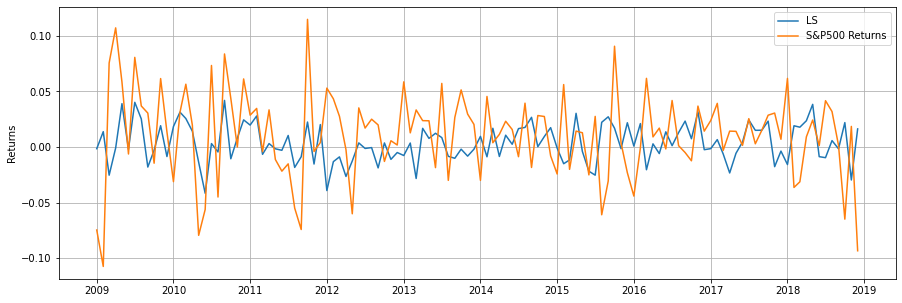

In [ ]:
plot_returns(port_plot3[['LS','S&P500 Returns']])

In [ ]:
#port_plot3 = port_plot3.drop(columns = ['short', 'long'])

In [ ]:
#port_plot3 = port_plot3.iloc[:50]

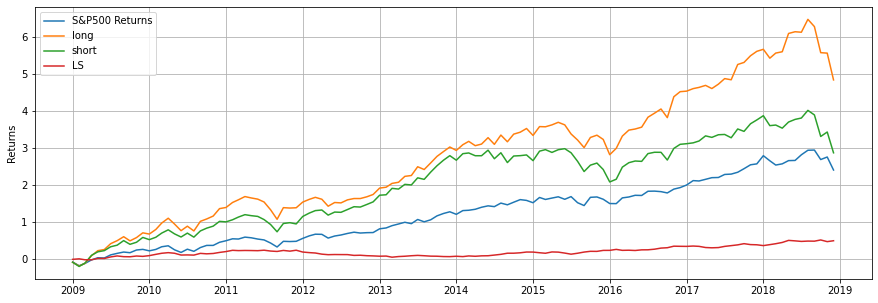

In [ ]:
plot_returns((1+port_plot3).cumprod()-1)

In [ ]:
from pandas_datareader.famafrench import get_available_datasets
datasets = get_available_datasets()
print(datasets)

['F-F_Research_Data_Factors', 'F-F_Research_Data_Factors_weekly', 'F-F_Research_Data_Factors_daily', 'F-F_Research_Data_5_Factors_2x3', 'F-F_Research_Data_5_Factors_2x3_daily', 'Portfolios_Formed_on_ME', 'Portfolios_Formed_on_ME_Wout_Div', 'Portfolios_Formed_on_ME_Daily', 'Portfolios_Formed_on_BE-ME', 'Portfolios_Formed_on_BE-ME_Wout_Div', 'Portfolios_Formed_on_BE-ME_Daily', 'Portfolios_Formed_on_OP', 'Portfolios_Formed_on_OP_Wout_Div', 'Portfolios_Formed_on_OP_Daily', 'Portfolios_Formed_on_INV', 'Portfolios_Formed_on_INV_Wout_Div', 'Portfolios_Formed_on_INV_Daily', '6_Portfolios_2x3', '6_Portfolios_2x3_Wout_Div', '6_Portfolios_2x3_weekly', '6_Portfolios_2x3_daily', '25_Portfolios_5x5', '25_Portfolios_5x5_Wout_Div', '25_Portfolios_5x5_Daily', '100_Portfolios_10x10', '100_Portfolios_10x10_Wout_Div', '100_Portfolios_10x10_Daily', '6_Portfolios_ME_OP_2x3', '6_Portfolios_ME_OP_2x3_Wout_Div', '6_Portfolios_ME_OP_2x3_daily', '25_Portfolios_ME_OP_5x5', '25_Portfolios_ME_OP_5x5_Wout_Div', '25_

In [ ]:
import pandas_datareader.data as web  # module for reading datasets directly from the web
r = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=1985)[0]/100
r = r.reset_index()
r['Date'] = r['Date'].dt.to_timestamp(freq='M')
r['Date']= pd.to_datetime(r['Date'], format='%Y-%m')
r['YEAR'] = pd.DatetimeIndex(r['Date']).year
r['month'] = pd.DatetimeIndex(r['Date']).month
rf = r[['YEAR','month','RF','Mkt-RF','SMB','HML']]

In [ ]:
m = web.DataReader('F-F_Momentum_Factor', 'famafrench', start=1985)[0]/100

In [ ]:
m = m.reset_index()
m['Date'] = m['Date'].dt.to_timestamp(freq='M')
m['Date']= pd.to_datetime(m['Date'], format='%Y-%m')
m['YEAR'] = pd.DatetimeIndex(m['Date']).year
m['month'] = pd.DatetimeIndex(m['Date']).month
m['MOM'] = m['Mom   ']
m = m[['MOM','YEAR','month']]

In [ ]:
CA4 = pd.merge(m[['month', 'YEAR','MOM']], rf, left_on = ['month', 'YEAR'], right_on = ['month', 'YEAR'])

In [ ]:
portfolio = pd.merge(port, CA4, left_on = ['month', 'YEAR'], right_on = ['month', 'YEAR'])

In [ ]:
portfolio['long_excess_return'] = portfolio['long']-portfolio['RF']
portfolio['short_excess_return'] = portfolio['short']-portfolio['RF']
portfolio['LS_excess_return'] = portfolio['LS']-portfolio['RF']

In [ ]:
short_returns_mean = portfolio['short'].mean()
long_returns_mean = portfolio['long'].mean()
LS_returns_mean = portfolio['LS'].mean()
print(f'Short portfolio simple mean return is {short_returns_mean*100:.2f}%')
print(f'Long portfolio simple mean return is {long_returns_mean*100:.2f}%')
print(f'Long Short portfolio simple mean return is {LS_returns_mean*100:.2f}%')

Short portfolio simple mean return is 1.28%
Long portfolio simple mean return is 1.63%
Long Short portfolio simple mean return is 0.35%


In [ ]:
short_returns_geo = gmean(1+portfolio['short'])-1
long_returns_geo = gmean(1+portfolio['long'])-1
LS_returns_geo = gmean(1+portfolio['LS'])-1
print(f'Short portfolio geometric mean return is {short_returns_geo*100:.2f}%')
print(f'Long portfolio geometric mean return is {long_returns_geo*100:.2f}%')
print(f'Long Short portfolio geometric mean return is {LS_returns_geo*100:.2f}%')

Short portfolio geometric mean return is 1.13%
Long portfolio geometric mean return is 1.48%
Long Short portfolio geometric mean return is 0.34%


In [ ]:
portfolio_annual_long = portfolio[['long','YEAR','month']]
portfolio_annual_long = portfolio_annual_long.groupby(['YEAR']).agg({'long': lambda x: ((1+x).product() ** (12/float(len(x)))-1)})

In [ ]:
portfolio_annual_short = portfolio[['short','YEAR','month']]
portfolio_annual_short = portfolio_annual_short.groupby(['YEAR']).agg({'short': lambda x: ((1+x).product() ** (12/float(len(x)))-1)})

In [ ]:
portfolio_annual_ls = portfolio[['LS','YEAR','month']]
portfolio_annual_ls = portfolio_annual_ls.groupby(['YEAR']).agg({'LS': lambda x: ((1+x).product() ** (12/float(len(x)))-1)})

In [ ]:
portfolio_annual_long = portfolio[['long','YEAR','month']]
portfolio_annual_long = portfolio_annual_long.groupby(['YEAR']).agg({'long': lambda x: ((1+x).product() ** (12/float(len(x)))-1)})
portfolio_annual_long1 = gmean(1+portfolio_annual_long['long'])-1
portfolio_annual_short = portfolio[['short','YEAR','month']]
portfolio_annual_short = portfolio_annual_short.groupby(['YEAR']).agg({'short': lambda x: ((1+x).product() ** (12/float(len(x)))-1)})
portfolio_annual_short1 = gmean(1+portfolio_annual_short['short'])-1
portfolio_annual_ls = portfolio[['LS','YEAR','month']]
portfolio_annual_ls = portfolio_annual_ls.groupby(['YEAR']).agg({'LS': lambda x: ((1+x).product() ** (12/float(len(x)))-1)})
portfolio_annual_ls1 = gmean(1+portfolio_annual_ls['LS'])-1
print(f'Long portfolio annualized return is {portfolio_annual_long1*100:.2f}%')
print(f'Short portfolio annualized return is {portfolio_annual_short1*100:.2f}%')
print(f'Long short portfolio annualized return is {portfolio_annual_ls1*100:.2f}%')

Long portfolio annualized return is 19.28%
Short portfolio annualized return is 14.49%
Long short portfolio annualized return is 4.13%


In [ ]:
short_p2_sharpe = portfolio['short_excess_return'].mean() / portfolio['short_excess_return'].std()
short_p2_sharpe_annual = short_p2_sharpe * (12**0.5)
long_p2_sharpe = portfolio['long_excess_return'].mean() / portfolio['long_excess_return'].std()
long_p2_sharpe_annual = long_p2_sharpe * (12**0.5)
LS_p2_sharpe = portfolio['LS_excess_return'].mean() / portfolio['LS_excess_return'].std()
LS_p2_sharpe_annual = LS_p2_sharpe * (12**0.5)
print(f'Short portfolio annualized Sharpe ratio is {short_p2_sharpe_annual:.2f}')
print(f'Long portfolio annualized Sharpe ratio is {long_p2_sharpe_annual:.2f}')
print(f'Long short portfolio annualized Sharpe ratio is {LS_p2_sharpe_annual:.2f}')

Short portfolio annualized Sharpe ratio is 0.79
Long portfolio annualized Sharpe ratio is 0.99
Long short portfolio annualized Sharpe ratio is 0.66


In [ ]:
returns6 = pd.DataFrame()
returns6['Simple_Mean'] = portfolio[['long','short','LS']].mean()
returns6.loc['long','GeoMean'] = (gmean(1+portfolio['long'])-1)
returns6.loc['short','GeoMean'] = (gmean(1+portfolio['short'])-1)
returns6.loc['LS','GeoMean'] = (gmean(1+portfolio['LS'])-1)
returns6.loc['long','Sharpe'] = (portfolio['long_excess_return'].mean() / portfolio['long_excess_return'].std())*(12**0.5)
returns6.loc['short','Sharpe'] = (portfolio['short_excess_return'].mean() / portfolio['short_excess_return'].std())*(12**0.5)
returns6.loc['LS','Sharpe'] = (portfolio['LS_excess_return'].mean() / portfolio['LS_excess_return'].std())*(12**0.5)

In [ ]:
returns6 # Monthly

,Simple_Mean,GeoMean,Sharpe
long,0.016333,0.014802,0.991159
short,0.012805,0.011337,0.793186
LS,0.003528,0.003382,0.657917


In [ ]:
portfolio = portfolio.rename(columns={'Mkt-RF':'MKT'})

In [ ]:
CAPM1 = smf.ols(formula='LS ~ MKT', data=portfolio).fit(cov_type='HAC',cov_kwds={'maxlags':1}) # I adjusted for autocorrelation because now this is a time series regression
FF31 = smf.ols(formula='LS ~ MKT + SMB + HML', data=portfolio).fit(cov_type='HAC',cov_kwds={'maxlags':1})
CH41 = smf.ols(formula='LS ~ MKT + SMB + HML + MOM', data=portfolio).fit(cov_type='HAC',cov_kwds={'maxlags':1})

In [ ]:
print(summary_col([CAPM1,FF31,CH41], model_names=['Long Short CAPM', 'Long Short FF3', 'Long Short CH4'],stars=True,regressor_order=['Intercept','MKT','SMB','HML','UMD']))


               Long Short CAPM Long Short FF3 Long Short CH4
------------------------------------------------------------
Intercept      0.0032**        0.0040***      0.0041***     
               (0.0016)        (0.0015)       (0.0015)      
MKT            0.0256          -0.0188        -0.0108       
               (0.0480)        (0.0525)       (0.0520)      
SMB                            0.0085         0.0107        
                               (0.0710)       (0.0722)      
HML                            0.1852***      0.2099***     
                               (0.0664)       (0.0726)      
MOM                                           0.0403        
                                              (0.0410)      
R-squared      0.0036          0.0760         0.0855        
R-squared Adj. -0.0049         0.0521         0.0537        
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [ ]:
CAPM1 = smf.ols(formula='long ~ MKT', data=portfolio).fit(cov_type='HAC',cov_kwds={'maxlags':1}) # I adjusted for autocorrelation because now this is a time series regression
FF31 = smf.ols(formula='long ~ MKT + SMB + HML', data=portfolio).fit(cov_type='HAC',cov_kwds={'maxlags':1})
CH41 = smf.ols(formula='long ~ MKT + SMB + HML + MOM', data=portfolio).fit(cov_type='HAC',cov_kwds={'maxlags':1})

In [ ]:
print(summary_col([CAPM1,FF31,CH41], model_names=['Long CAPM', 'Long FF3', 'Long CH4'],stars=True,regressor_order=['Intercept','MKT','SMB','HML','UMD']))


               Long CAPM  Long FF3  Long CH4 
---------------------------------------------
Intercept      0.0025    0.0047*** 0.0045*** 
               (0.0019)  (0.0011)  (0.0010)  
MKT            1.2549*** 1.0214*** 0.9865*** 
               (0.0671)  (0.0476)  (0.0360)  
SMB                      0.7738*** 0.7642*** 
                         (0.0675)  (0.0542)  
HML                      0.1730*** 0.0639    
                         (0.0650)  (0.0562)  
MOM                                -0.1780***
                                   (0.0471)  
R-squared      0.8171    0.9294    0.9469    
R-squared Adj. 0.8156    0.9276    0.9451    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [ ]:
CAPM1 = smf.ols(formula='short ~ MKT', data=portfolio).fit(cov_type='HAC',cov_kwds={'maxlags':1}) # I adjusted for autocorrelation because now this is a time series regression
FF31 = smf.ols(formula='short ~ MKT + SMB + HML', data=portfolio).fit(cov_type='HAC',cov_kwds={'maxlags':1})
CH41 = smf.ols(formula='short ~ MKT + SMB + HML + MOM', data=portfolio).fit(cov_type='HAC',cov_kwds={'maxlags':1})

In [ ]:
print(summary_col([CAPM1,FF31,CH41], model_names=['Short CAPM', 'Short FF3', 'Short CH4'],stars=True,regressor_order=['Intercept','MKT','SMB','HML','UMD']))


               Short CAPM Short FF3 Short CH4 
----------------------------------------------
Intercept      -0.0008    0.0007    0.0005    
               (0.0019)   (0.0014)  (0.0011)  
MKT            1.2294***  1.0402*** 0.9973*** 
               (0.0681)   (0.0442)  (0.0300)  
SMB                       0.7653*** 0.7535*** 
                          (0.0630)  (0.0481)  
HML                       -0.0122   -0.1460***
                          (0.0569)  (0.0459)  
MOM                                 -0.2183***
                                    (0.0293)  
R-squared      0.8248     0.9258    0.9535    
R-squared Adj. 0.8233     0.9239    0.9519    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
